Для этой домашней работы я взяла 12 детских сказок разных авторов.

Импорты:

In [243]:
import os
from pymystem3 import Mystem

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
import logging

import zipfile
import wget

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from pymorphy2 import MorphAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns

### 1 часть. Подготовка текстов

In [208]:
m = Mystem() #класс для дальнейшей лемматизации
sw = stopwords.words('russian') #стоп-слова

files = os.listdir('./texts')
for fname in files: 
    with open(f'./texts/{fname}', 'r', encoding = 'utf-8') as f:
        text = f.read()
        #делим текст на предложения
        sentences = sent_tokenize(text)
        for sent in sentences:
            lemmas = m.lemmatize(sent)
            #убираем пунктуацию и приводим все к строчному написанию
            words = [w.lower() for w in lemmas if w.isalpha()]
            #убираем стоп-слова
            filtered = [w for w in words if w not in sw]
            result = ' '.join(filtered)
            
            #открываем файл, в который будем записывать по предложению 
            #обработанные тексты для каждой из сказок
            with open('ready.txt', 'a', encoding = 'utf-8') as f:
                f.write(result)
                f.write("\n")

### 2 часть. Обучение модели

**1. Обучите модель как показано в конспекте по word2vec с параметрами...**

- размер вектора 300
- минимальное количество вхождений 5
- окно 5
- количество итераций 50

In [209]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

f = "ready.txt"
data = gensim.models.word2vec.LineSentence(f)
model_tales = gensim.models.Word2Vec(data, vector_size=300, window=5, min_count=5, epochs=50)

2022-11-15 23:15:42,717 : INFO : collecting all words and their counts
2022-11-15 23:15:42,720 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-15 23:15:42,788 : INFO : PROGRESS: at sentence #10000, processed 74793 words, keeping 11367 word types
2022-11-15 23:15:42,829 : INFO : PROGRESS: at sentence #20000, processed 126028 words, keeping 14211 word types
2022-11-15 23:15:42,874 : INFO : PROGRESS: at sentence #30000, processed 182440 words, keeping 17135 word types
2022-11-15 23:15:42,910 : INFO : PROGRESS: at sentence #40000, processed 231815 words, keeping 18500 word types
2022-11-15 23:15:42,921 : INFO : collected 19086 word types from a corpus of 243796 raw words and 42492 sentences
2022-11-15 23:15:42,922 : INFO : Creating a fresh vocabulary
2022-11-15 23:15:42,954 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 6853 unique words (35.91% of original 19086, drops 12233)', 'datetime': '2022-11-15T23:15:42.954665', 'gensim':

**2. Сколько слов оказалось в словаре? Это много или мало?**

In [210]:
print(len(model_tales.wv.key_to_index))

6853


Это очень мало, если сравнивать с размерами корпусов в моделях на RusVectores (которые измеряются в миллионах и миллиардах слов)

**3 + 4. Найдите ближайшие 10 слов...**

- для абстрактного понятия

In [215]:
model_tales.wv.most_similar('завтра', topn=10)

[('суббота', 0.5760028958320618),
 ('пятница', 0.5729019641876221),
 ('сегодня', 0.483368843793869),
 ('вахтенный', 0.47634968161582947),
 ('послезавтра', 0.47614550590515137),
 ('наставать', 0.4361511170864105),
 ('окончание', 0.426241934299469),
 ('вова', 0.4154715836048126),
 ('календарь', 0.40955060720443726),
 ('видеться', 0.4061753749847412)]

Такой результат вполне ожидаем. В числе ближайших соседей оказываются слова, связанные c обозначением дней недели или с понятием времени. Среди неожиданных соседей - 'вова', 'вахтенный'. Синонимов в выдаче нет, антоним - 'сегодня'.

- для имени героя

In [212]:
model_tales.wv.most_similar('настя', topn=10)

[('рита', 0.6461926102638245),
 ('вселяться', 0.5295249223709106),
 ('кукла', 0.44030559062957764),
 ('поцеловать', 0.4391626715660095),
 ('чуланчик', 0.43448036909103394),
 ('мама', 0.4173473119735718),
 ('папа', 0.4081573784351349),
 ('старушка', 0.4079175591468811),
 ('ванная', 0.39764198660850525),
 ('ласково', 0.39640486240386963)]

Результаты выдачи довольно неожиданны. Среди 'рита', 'мама', 'папа', 'старушка', вполне предсказуемых в роли ближайших слов для имени героя, встречаются слова 'ванная' и 'чуланчик', семантическая близость которых с именем 'настя' кажется неочевидной.  

Антонимов и синонимов в ближайших к слову нет (а могут ли они быть у имени собственного?)

- для прилагательных хороший и плохой (или других антонимов)

In [213]:
model_tales.wv.most_similar('хороший', topn=10)

[('плохой', 0.40871861577033997),
 ('итак', 0.3804191052913666),
 ('нечестный', 0.3752884566783905),
 ('жестокий', 0.3625962734222412),
 ('разрешаться', 0.3588060438632965),
 ('пригожий', 0.35352227091789246),
 ('даром', 0.3367367088794708),
 ('наказывать', 0.33632892370224),
 ('замечательный', 0.3346986472606659),
 ('жаловаться', 0.33463358879089355)]

Результат вполне соответствует тому, что мы ожидали увидеть. В ближайших соседях прилагательного 'хороший' оказываются слова с положительной и отрицательной оценкой. Из неожиданных соседей - 'итак'. В ближайших к слову есть антоним 'плохой' и синоним (?) 'замечательный'.

In [214]:
model_tales.wv.most_similar('плохой', topn=10)

[('неплохой', 0.4671472907066345),
 ('отметка', 0.4516538381576538),
 ('никудышный', 0.41977444291114807),
 ('шутка', 0.4133642911911011),
 ('поделать', 0.41198214888572693),
 ('хороший', 0.40871867537498474),
 ('мяукать', 0.4020572304725647),
 ('подобный', 0.39945387840270996),
 ('додумываться', 0.39495256543159485),
 ('считать', 0.3931252062320709)]

Результат ожидаем. В выдаче ближайших к слову соседей оказыватся прилагательные с оценкой, существительные, обозначающие объекты которые могут быть оценены как плохие. Из неожиданных соседей - 'мяукать', 'додумываться', 'поделать'. Кроме того среди ближайших к слову встречаются как синонимы ('никудышный'), так и антонимы ('хороший', 'неплохой').

**Говорит ли это что-то о самом корпусе?** 

Выдача ближайших слов к данным четырем словам позволяет нам судить об особенности языка текстов в корпусе в целом. Тексты, которые были использованы для создания корпуса, представляют собой сказки (не русские народные, а написанные атворами 20-21 вв.). Для них характерен особенный язык: использование характерных речевых оборотов, характерных слов (чуланчик, пригожий, никудышный, старушка). Они в первую очередь предназначены для детей, поэтому язык достаточно простой, без терминов и сложных понятий.

**5. Найдите лишнее слово в ряду. Соответствует ли результат ожиданиям или модель ошиблась?**

In [217]:
model_tales.wv.doesnt_match("отец мама сестра мальчик бабушка".split())

'мальчик'

Модель не ошиблась. Все слова (кроме 'мальчик') в строке имеют один общий компонент значения - 'родственник'. Несмотря на то что 'мальчик' имеет общие компоненты значения с некоторыми (компонент значения 'мужчина' у слов 'отец', 'мальчик') или со всеми (компонент значения 'человек') словами из строки, он отличается от них всех именно тем, что 'мальчик' - НЕ 'родственник'. Ни у какого другого слова из строки нет такого компонента значения, который отличал бы его от остальных, поэтому модель не ошиблась с выбором лишнего слова.

Это потверждается добавлением в строку неодушевленного существительного 'чайник', которое будет отличаться от всех слов в строке отсутствием в значении компонента 'человек':

In [216]:
model_tales.wv.doesnt_match("отец мама чайник сестра мальчик бабушка".split())

'чайник'

Модель снова верно определила лишнее слово.

### 3 часть.

#### 3.1. W2V

**1. Загрузка Word2Vec модели**

In [219]:
model_url = 'http://vectors.nlpl.eu/repository/20/180.zip'
#загружаем зип файл
m = wget.download(model_url)
with zipfile.ZipFile('180.zip', 'r') as archive:
    #разархивируем
    archive.extractall('model180')

100% [..................................................] 484452317 / 484452317

In [220]:
model = gensim.models.KeyedVectors.load_word2vec_format('./model180/model.bin', binary=True)

2022-11-15 23:34:23,812 : INFO : loading projection weights from ./model180/model.bin
2022-11-15 23:34:25,728 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (189193, 300) matrix of type float32 from ./model180/model.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-11-15T23:34:25.728400', 'gensim': '4.2.0', 'python': '3.9.7 (v3.9.7:1016ef3790, Aug 30 2021, 16:39:15) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'load_word2vec_format'}


Примеры данных (смотрим, какие частеречные тэги используются в модели (пригодится в следующих пунктах для создания своих примеров)):

In [226]:
print([w for w in model.key_to_index][0:100])

['так_ADV', 'быть_VERB', 'мочь_VERB', 'год_NOUN', 'человек_NOUN', 'xxxxxx_NUM', 'сказать_VERB', 'еще_ADV', 'один_NUM', 'говорить_VERB', 'уже_ADV', 'другой_ADJ', 'время_NOUN', 'xxxxxxxx_NUM', 'знать_VERB', 'сам_ADJ', 'самый_ADJ', 'делать_VERB', 'дело_NOUN', 'день_NOUN', 'жизнь_NOUN', 'видеть_VERB', 'как_ADV', 'рука_NOUN', 'очень_ADV', 'два_NUM', 'первый_ADJ', 'новый_ADJ', 'давать_VERB', 'где_ADV', 'слово_NOUN', 'становиться_VERB', 'теперь_ADV', 'раз_NOUN', 'должен_ADJ', 'иметь_VERB', 'идти_VERB', 'большой_ADJ', 'там_ADV', 'можно_ADV', 'глаз_NOUN', 'xxxxxxx_NUM', 'лицо_NOUN', 'хотеть_VERB', 'место_NOUN', 'понимать_VERB', 'более_ADV', 'смотреть_VERB', 'потом_ADV', 'каждый_ADJ', 'нет_VERB', 'работа_NOUN', 'казаться_VERB', 'тогда_ADV', 'писать_VERB', 'здесь_ADV', 'тут_ADV', 'голова_NOUN', 'оставаться_VERB', 'надо_ADV', 'сторона_NOUN', 'потому_ADV', 'друг_NOUN', 'спрашивать_VERB', 'думать_VERB', 'брать_VERB', 'начинать_VERB', 'жить_VERB', 'дом_NOUN', 'приходить_VERB', 'выходить_VERB', 'после

**2. Семантическая пропорция**

брат - мужчина + женщина = сестра

In [228]:
model.most_similar(positive=['брат_NOUN', 'женщина_NOUN'], negative=['мужчина_NOUN'])[0][0]

'сестра_NOUN'

**3. Визуализация с помощью PCA названий животных**

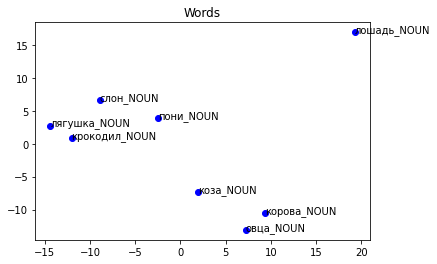

In [229]:
words = ['крокодил_NOUN', 'корова_NOUN', 'лягушка_NOUN', 'овца_NOUN', 'лошадь_NOUN', 'слон_NOUN', 'коза_NOUN', 'пони_NOUN']
X = model[words]
pca = PCA(n_components=2)
coords = pca.fit_transform(X)
plt.scatter(coords[:, 0], coords[:, 1], color='blue')
plt.title('Words')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

Результат, конечно, похож на правду, но не совсем. С одной стороны, вектора названий домашних животных находятся близко друг к другу (в одной области на графике), как и вектора названий экзотических животных. Однако, удивительно, во-первых, что вектор 'лошади' находится на графике так далеко от векторов других домашних животных с копытами, во-вторых, что вектор 'пони' расположен ближе к экзотическим животных, чем к 'лошади'. С точки зрения человеческого жизненного опыта кажется, что вектора этих двух названий должны быть достаточно близко на графике.

**4. Замена слов в предложении на ближайшие по векторам.**

In [232]:
m = Mystem()
morph = MorphAnalyzer()

sentence = "Высшая школа экономики, как и высшая математика, имеет много общего с высшей логикой."
#предложение может быть немного бессмысленным, поскольку сгенерировано Балабобой
sentence_new = '' 

lemmas = m.lemmatize(sentence)
lemmas_filtered = [w.lower() for w in lemmas if w.isalpha()]
for w in lemmas_filtered:
    #добавляем частеречные теги к словам в нашем предложении, чтобы потом использовать их в most_similar
    ana = morph.parse(w)
    word_pos = ana[0].tag.POS
    
    #тэги некоторых частей речи отличаются от тэгов в корпусе в модели, поэтому заменяем их на правильные
    if word_pos == 'ADJF':
        word_pos = 'ADJ'
    elif word_pos == 'INFN':
        word_pos = 'VERB'
    elif word_pos == 'ADVB':
        word_pos = 'ADV'
    
    #готовое слово вида слово_ЧАСТЬРЕЧИ для most_similar
    word = w + '_' + word_pos
    
    if word in model:
        #поиск ближайшего по векторам слова
        similar_word_in_model = model.most_similar(word, topn=1)[0][0]
        similar_word = similar_word_in_model.split('_')[0] + ' '
        sentence_new += similar_word 
    else:
        #вывод служебных слов
        sentence_new += w + ' '
        
print(sentence_new)

2022-11-15 23:43:28,095 : INFO : Loading dictionaries from /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pymorphy2_dicts_ru/data
2022-11-15 23:43:28,203 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


низкий школа экономический как и низкий математический иметься мало отдельный с низкий логический 


Низкая школа экономическая, как и низкая математическая, имеет мало отдельного с низкой логической. 

#### 3.2. TF-IDF

**1. Возьмите статьи (20-100) из Википедии на разные темы (например, про города, страны, математику, историю, языки), подготовьте для построения TF-IDF (лемматизируйте)**

Я взяла 40 статей на 5 тем (живопись, страны, языки, физика, музыкальные группы).

In [233]:
articles_texts = []
articles_names = []
files = os.listdir('./wikiarticles')
for fname in files:
    with open(f"./wikiarticles/{fname}", "r", encoding="utf-8") as f:
        #список с текстами всех статей
        articles_texts.append("\n".join(f.readlines()))
        #будем вытаскивать отсюда названия файлов
        articles_names.append(fname)

#подготовка текстов 
articles_preprocessed = []
for a_text in articles_texts:
    a_text = a_text.replace("[править | править код]", "")
    a_text = a_text.replace("[показать]", "")
    lemmas = m.lemmatize(a_text)
    words = [w.lower() for w in lemmas if w.isalpha()]
    ready_text = ' '.join(words)
    articles_preprocessed.append(ready_text)

**2. Постройте TF-IDF для статей. Параметры от 1 до 3 слов (ngram_range=(1,3)), встретились минимум 3 раза (min_df=3).**

In [234]:
stops = stopwords.words("russian")
tfidf = TfidfVectorizer(
    analyzer="word", 
    stop_words=stops, 
    ngram_range = (1,3),
    min_df=3
)

#построение tf-idf для статей
articles_tfidf = tfidf.fit_transform(articles_preprocessed)
print(f"Матрица на {articles_tfidf.shape[0]} документов и {articles_tfidf.shape[1]} термов")

Матрица на 40 документов и 6922 термов


**3. Выделите для статей ключевые слова, покажите их и оцените, насколько это соответствует их содержанию и вашим ожиданиям.**

In [236]:
def get_top_tf_idf_words(tfidf_vector, feature_names, top_n):
    sorted_nzs = np.argsort(tfidf_vector.data)[:-(top_n+1):-1]
    return feature_names[tfidf_vector.indices[sorted_nzs]]

feature_names = np.array(tfidf.get_feature_names())

for i, article in enumerate(articles_texts):
    article_vector = articles_tfidf[i, :]
    words = get_top_tf_idf_words(article_vector, feature_names, 10)
    print("Имя файла: ", articles_names[i])
    print("Ключевые слова: ", words, "\n")

Имя файла:  czech.txt
Ключевые слова:  ['чешский' 'язык' 'число' 'род' 'ед число' 'мн число' 'падеж' 'ед'
 'согласный' 'лицо'] 

Имя файла:  cubism.txt
Ключевые слова:  ['кубизм' 'пикассо' 'художник' 'искусство' 'картина' 'год' 'форма' 'брак'
 'живопись' 'аполлинер'] 

Имя файла:  belarusian.txt
Ключевые слова:  ['белорусский' 'белорусский язык' 'язык' 'слово' 'наречие' 'числительное'
 'год' 'местоимение' 'русский' 'говор'] 

Имя файла:  sbpch.txt
Ключевые слова:  ['альбом' 'кирилл' 'год' 'группа' 'простой' 'запись' 'игрушка'
 'самый большой' 'музыкант' 'большой'] 

Имя файла:  swedish.txt
Ключевые слова:  ['шведский' 'слушать' 'язык' 'диалект' 'швеция' 'финляндия'
 'существительное' 'артикль' 'стандартный' 'en'] 

Имя файла:  postmodern.txt
Ключевые слова:  ['общество' 'индустриальный' 'социальный' 'эпоха' 'понятие' 'производство'
 'период' 'культура' 'который' 'исторический период'] 

Имя файла:  bulgarian.txt
Ключевые слова:  ['болгарский' 'язык' 'сто' 'форма' 'глагол' 'болгария' 'с

Ключевые слова для каждой статьи соответствуют и моим ожиданиям, и её содержанию.

Из неожиданных и не соответствующих - ключевое слово 'тыс' для статьи про Беларусь (сокращение от 'тысяч'), и часто встречающиеся в разных статьях в качестве ключевых слов 'год', 'of', 'the'. Эти слова не являются ключевыми и не передают содержание статьи. Они попадают в список ключевых для текста из-за большой частотности в этом тексте.

**4. Визуализация TF-IDF вектора текстов с помощью PCA**

1 - czech.txt
2 - cubism.txt
3 - belarusian.txt
4 - sbpch.txt
5 - swedish.txt
6 - postmodern.txt
7 - bulgarian.txt
8 - bi2.txt
9 - ukranian.txt
10 - redvelvet.txt
11 - queen.txt
12 - czechcountry.txt
13 - russian.txt
14 - french.txt
15 - pointilism.txt
16 - italy.txt
17 - abstact_expressionsim.txt
18 - abba.txt
19 - popart.txt
20 - english.txt
21 - ukrain.txt
22 - radiohead.txt
23 - realism.txt
24 - surrealism.txt
25 - physics5.txt
26 - physics4.txt
27 - dadaism.txt
28 - physics6.txt
29 - 3oh!3.txt
30 - italian.txt
31 - dajtetank.txt
32 - physics3.txt
33 - physics2.txt
34 - belarusia.txt
35 - portuguese.txt
36 - impressionism.txt
37 - france.txt
38 - physics1.txt
39 - uvula.txt
40 - theneighbourhood.txt


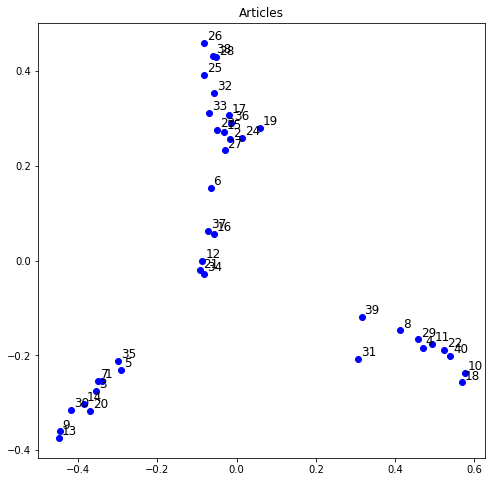

In [237]:
articles_data = pd.DataFrame(articles_tfidf.toarray()).values.tolist() #вектора текстов

X = articles_data
pca = PCA(n_components = 2)
coords = pca.fit_transform(X)
plt.figure(figsize=(8, 8))
plt.scatter(coords[:, 0], coords[:, 1], color='blue')
plt.title('Articles')

for i in range(articles_tfidf.shape[0]):
    plt.annotate(i+1, xy=(coords[i, 0], coords[i, 1]), fontsize=12, xytext = (3, 3), textcoords='offset points')
    print(i+1,'-', articles_names[i]) 
plt.show()

**Правда ли, что похожие тексты находятся рядом?**

Рассмотрим области "скопления" точек на графике.

В первой области (из тех, что мы собираемся рассмотреть) близко друг к другу расположены точки 1, 3, 5, 7, 9, 13, 14, 20, 30, 35. Каждая из точек соответствует статье, связанной с каким-то языком (см. "легенду" над графиком, в которой для каждой цифры указано название документа/статьи).
Причем можно даже проследить некоторую закономерность в расположении точек относительно того, к какой языковой группе принадлежит язык, которому посвящена статья. Так на графике точки 7, 1 и 3 расположены друг к другу ближе, чем к остальным. Это статьи, посвященный славянским языкам. Ту же закономерность можно увидеть на примере точек 9 и 13 (славянские языки восточной подгруппы), а также 30 и 14 (романские языки).

Во второй области мы видим скопление точек 12, 21 и 34 - это статьи про Чехию, Украину и Беларусь. Чуть выше - точки 16 и 37, статьи про Италию и Францию. То есть статьи про страны группируются таким же образом, как и статьи про соответствующие языки, только в другой области на графике.

Выше этого скопления - точка 6, статья про постмодерн. Предполагалось, что она будет ближе к точкам статей про искусство, однако, она оказалась отдельно от них, ниже на графике. 

Самое высокое на графике скопление точек - статьи про физику (25, 26, 28, 32, 33, 38). И, почему-то, очень близко к статьям про физику находятся статьи про искусство (2, 15, 17, 19, 23, 24, 27, 36).

Скопление статей в правом нижнем углу - статьи про музыкальные группы (4, 8, 10, 11, 18, 22, 29, 31, 39, 40)

Таким образом, **гипотеза о том, что тексты с похожей тематикой находятся рядом, подтвердилась**.


### 4 часть.

**1. Попробуйте разобраться с параметром token_pattern, как задать параметр так, чтобы числа не попадали в словарь?**

Параметр token_pattern задается с помощью регулярного выражения. По умолчанию token pattern = '(?u)\b\w\w+\b'. С помощью этой регулярки находятся слова, состоящие из двух и более знаков, не содержащие знаки препинания но (!) содержащие цифры или состоящие из них полностью. 

Следовательно, чтобы исключить числа из словаря, нужно написать такое регулярное выражение для параметра token_pattern, которое бы исключало числа из поиска.

In [238]:
#cделать это можно, например, вот так:
tfidf = TfidfVectorizer(
    analyzer='word', 
    token_pattern = '(?u)\b[^\d\W]+\b'
)

**2. Прочитайте про метрику cosine_similarity в sklearn. С помощью нее постройте матрицу схожести текстов на основе их векторов.
Возьмите один из текстов и выведите тексты, которые наиболее на него похожи**

In [241]:
def max_cosine_similarity(data, article_number):
    #создаем матрицу схожести текстов на основе их векторов
    cos_sim = cosine_similarity(data, data)
    
    #из списка будем вытаскивать максимальные значения близости для текста
    sentence_cos_sim = list(cos_sim[article_number-1])
    #article_number - номер текста для нас, (article_number-1) - индекс текста в списке
    
    for i in range(0,4):
        max_number = max(sentence_cos_sim)
        sim_article_index = sentence_cos_sim.index(max_number)

        #приравниваем к 0, чтобы в дальнейшем нам выдавались другие значения, к-е меньше этого, но больше остальных
        sentence_cos_sim[sim_article_index] = 0

        #max_number в цикле будет сначал выдавать тот же cos_sim[article_number-1]
        #поскольку для него значение будет максимально и равно 1 (ведь это один и тот же текст)
        #так что мы исключаем эту ситуацию
        if sim_article_index != article_number-1:
            print(sim_article_index+1)
        
max_cosine_similarity(articles_data, 12)

1
34
21


См. пункт 4 части 3.2
К тексту 12 (про Чехию) действительно близки текста 21 и 34 (они про другие страны), как и текст 1 (он про чешский язык)

**3. Прочитайте про seaborn clustermap и попробуйте визуализировать матрицу близости.**

Тут я пыталась, но не получилось, не успела

In [244]:
cos_sim = cosine_similarity(data, data)
sim_sns = pd.DataFrame(cos_sim, columns = articles_names, index = articles_names)
sns.clustermap(data = sim_sns)

TypeError: float() argument must be a string or a number, not 'LineSentence'

А тут что-то получилось, но, кажется, не совсем то

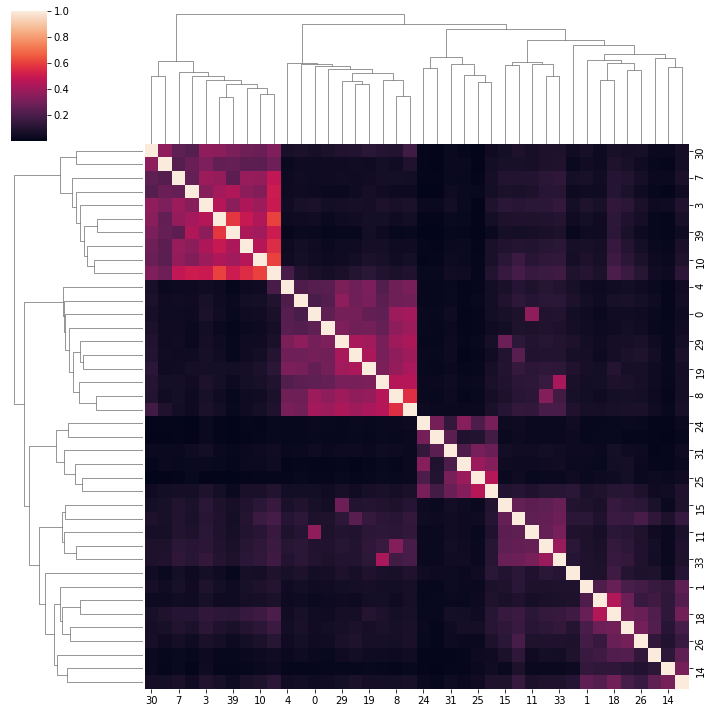

In [248]:
sns.clustermap(cos_sim)